In [1]:
%env MKL_THREADING_LAYER=GNU
%env THEANO_FLAGS=device=cuda,floatX=float64
# optimizer=fast_run,NanGuardMode.action=warn
# use device=cuda for gpu support

env: MKL_THREADING_LAYER=GNU
env: THEANO_FLAGS=device=cuda,floatX=float64


In [2]:
import sys
from __future__ import division
add = __builtin__.sum

In [3]:
from theano import clone, function, pp, shared
from theano.tensor import (concatenate, config, cosh, dot, erfinv, eq, grad, min,
                           scalar, scalars, shape_padright, sqrt, sum, switch,
                           tensor3, tensor5, TensorType, tile, vector)
from theano.printing import debugprint, pydotprint
#from theano.tensor.shared_randomstreams import RandomStreams
# used later
from theano.tensor import roll, stack

Using cuDNN version 7005 on context None
Mapped name None to device cuda: GeForce GTX 980 Ti (0000:01:00.0)


In [4]:
from numpy import (array, arange, asarray, exp, full, Inf, linspace,
                   mean, meshgrid, pi, roll)
# used later
#from numpy import roll, stack

In [5]:
from sympy import (Abs, Eq, exp as Exp, I, init_printing, integrate,
                   oo, Matrix, pi as Pi, solve, symbols, Symbol)
#from sympy.printing.theanocode
# added erfinv
from theanocode import theano_code, theano_function
#from pymatrix import matrix, Matrix

In [6]:
init_printing()

In [7]:
from IPython.display import display, HTML, SVG

In [8]:
%matplotlib inline
#import matplotlib
from matplotlib.pyplot import (axes, close, contour, contourf, figure, legend,
                               plot, scatter, show, title, xlabel, ylabel,
                               xlim,ylim)
from matplotlib.cm import * #coolwarm, Spectral
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation

In [9]:
from sdict import select
# E.g. select({3:3.2,2:2.2})[[2,3]] or
S=select({3:3.2,2:2.2})
S[array([2,3,2,2])]

array([ 2.2,  3.2,  2.2,  2.2])

In [10]:
from smatrix import *
# E.g.
print matrix([[1,2],[3,4]]).inverse()

-2   1

 1  -1


In [11]:
# function of specified variables fun(y,...) from expression f
# where: fun(x,y)(f)(x,y) = f
def fun(*y):
    try: # theano?
        return lambda f: lambda *x: clone(f, dict([[y[i],x[i]] for i in range(len(y))]),strict=False)
    except:
        return lambda f: lambda *x: f.subs( dict([[y[i],x[i]] for i in range(len(y))]))

The multidimensional symbolic array $C$ represents a "uniformizing" mapping of worlds into configuration space, i.e. the position of each particle in each world.

In [12]:
dim = range(2) # dimension
C = TensorType(config.floatX, (False,)*(1+len(dim)))('C') # shape: d * N**d

#### Boundary Conditions

We introduce fictitious worlds, two worlds deep, at the edges of the array to represent boundary conditions. Boundry worlds can be removed or set to zero.

In [13]:
B=2
def boundary0(r):
    for i in range(r.ndim):
        rs = list(r.shape); rs[i]=1
        s = [1]*r.ndim; s[i]=B
        before1 = tile(array([0]*B,config.floatX).reshape(*s),rs)
        s = [1]*r.ndim; s[i]=B
        after1 = tile(array([0]*B,config.floatX).reshape(*s),rs)
        r = concatenate([before1,r,after1], axis=i)
    return r

In [14]:
def boundary(s): return stack([boundary0(r) for r in s])

In [15]:
def debound(r): return r[tuple([slice(B,-B)]*(r.ndim))]

In [16]:
# uniform grid between 0 and 1 of dimension d and size N
def grid(d,N):
    return array(meshgrid(*[arange(0.0+0.5/N,1.0,1.0/N,config.floatX)]*d,
                              indexing='ij'))

In [17]:
# E.g.
grid(2,2)

array([[[ 0.25,  0.25],
        [ 0.75,  0.75]],

       [[ 0.25,  0.75],
        [ 0.25,  0.75]]])

In [18]:
boundary(grid(2,2)).eval()

array([[[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.25,  0.25,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.75,  0.75,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.25,  0.75,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.25,  0.75,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]]])

In [19]:
array(list(map(debound,boundary(grid(2,2)).eval())))

array([[[ 0.25,  0.25],
        [ 0.75,  0.75]],

       [[ 0.25,  0.75],
        [ 0.25,  0.75]]])

### Difference operator ###

In [20]:
# In the following use numpy's roll and stack. Later we will use theano for numerical versions of these operations.
from numpy import roll, stack

In [21]:
N=9

Symbolic grid.

In [22]:
var=['x','y']

In [23]:
xb=array([[[Symbol('%s_{%s\ %s}'%(var[k],str(Symbol("i")+(i-N//2)).replace(' ',''),str(Symbol("j")+(j-N//2)).replace(' ','')))
                             for j in range(N)] for i in range(N)]
                    for k in dim])
xb.shape

In [24]:
#xb=array(meshgrid(*[symbols(['%s_{%s}'%(var[j].replace(' ',''),str(Symbol("i")+(i-N//2)).replace(' ',''))
#                             for i in range(N)])
#                    for j in dim],indexing='ij'))
#xb.shape

In [25]:
xb[0,:,N//2].tolist()

In [26]:
xb[1,N//2,:].tolist()

The index of the $i^{th}$ world with boundry worlds removed:

In [27]:
x=array(map(debound,xb))

In [28]:
Matrix(x[0].tolist())

In [29]:
Matrix(x[1].tolist())

In [30]:
ith = N//2-B; jth = N//2-B
x_ij=x[0][ith,jth]
y_ij=x[1][ith,jth]
(x_ij,y_ij)

Forward and backward differences

In [31]:
def d(dir,x,i):
    if dir<0:
        return roll(x, dir, axis = i) - x
    else:
        return x - roll(x, dir, axis = i)

In [32]:
Matrix(debound(d(-1,xb[0],0)))

Does this make sense???  Should the cross-terms be 0?

In [33]:
Matrix(debound(d(-1,xb[0],1)))

#### Jacobian ####

In [34]:
def J(C): return matrix([[d(-1,C[j],i) for i in dim] for j in dim])

In [35]:
Matrix(J(x))

In [36]:
def K(C): return 1/J(C)

#### Density ####

In [37]:
def D(C): return 1/J(C).determinant()

In [38]:
Ds=D(x)
Ds.shape

In [39]:
Ds[ith,jth]

#### Quantum Potential (Schiff&Poirier eq. 20)####

In [40]:
hbar=Symbol('hbar') # Planck's constant

In [41]:
mu=array(symbols(['mu%s'%i for i in dim])) # mass
list(mu)

In [42]:
def Q(hbar,mu,C):
    K_C = K(C)
    return debound(add([add([add([
           -hbar**2/(4*mu[j])*(K_C[k,j]*d(-1,d(+1,K_C[l,j], k), l) + d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)/2)
                 for k in dim]) for j in dim]) for l in dim]))

The quantum potential at the $i^{th}$ world:

In [43]:
Qs=Q(hbar,mu,xb)
Qs.shape

The $i^{th}$ entry in this array is generic, i.e. independent of the worlds at the boundary.

In [44]:
Qs[ith,jth]

#### Quantum Force ####

In general the force is a vector.
Provided the number of worlds is large enough the trace of Q contains sufficient information to compute gradients.

In [45]:
QU=add([Qs[i,j] for i in range(N-2*B) for j in range(N-2*B)]) # total

In [46]:
R0 = -QU.diff(x_ij); #R0

In [47]:
R1 = -QU.diff(y_ij); #R1

These are the same expressions in different variables! If we have computed the gradients properly this means that the quantum force is "separable".  The forces on each axis (orthogonal directions) are independent of each other. Therefore the generalization to higher dimensions/multiple particles is essentially trivial.

 Schiff & Poirier eq 18

In [48]:
def R(hbar,mu,C):
    K_C=K(C)
    return stack([debound(add([add([add([add([
      hbar**2/(4*mu[j])*d(+1,K_C[k, i]*K_C[p, j]*d(-1,d(+1,K_C[l, j], k), l), p)
        for p in dim]) for k in dim]) for j in dim]) for l in dim]))
            for i in dim])

In [49]:
Rs=R(hbar,mu,xb)
Rs.shape

Again, the $ij^{th}$ entry in these arrays are generic, i.e. independent of the boundary worlds.

In [50]:
#Rs[0,ith,jth]

In [51]:
#Rs[1,ith,jth]

As expected, the discretized Schiff and Poirier expression for the quantum force is the gradient of the discretized quantum potential.

In [52]:
#print Rs[0,ith,ith].expand()==R0.expand()
#print Rs[1,ith,ith].expand()==R1.expand()

It is also interesting to note that the gradient of a simpler potential, which differs from the $2^{nd}$ order term in Schiff&Poirier eq. 20 by only the sign, yields the same expression for the quantum force. This turns out to be the same quantum potential as introduced by Hall&Deckart.

In [53]:
def Q2(hbar,mu,C):
    K_C = K(C)
    return debound(add([add([add([
           hbar**2/(8*mu[j])*d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)
                 for k in dim]) for j in dim]) for l in dim]))

In [54]:
Qs2=Q2(hbar,mu,xb)

The discretized version of this expression is identical to that introduced by Hall & Deckart.

In [55]:
Qs2[ith,jth]

Gradient of the trace.

In [56]:
Q2R0 = -add([Qs2[i,j] for i in range(N-2*B) for j in range(N-2*B)]).diff(x_ij)
Q2R1 = -add([Qs2[i,j] for i in range(N-2*B) for j in range(N-2*B)]).diff(y_ij)

In [57]:
#Q2R0

In [58]:
#(Rs[0,ith,ith] - Q2R0).expand()

In [59]:
#((Rs[0,ith,ith] - Q2R0).simplify()==0 and
# (Rs[1,ith,ith] - Q2R1).simplify()==0)

### Numeric computation ###

These expressions can be converted directly to Theano functions for efficient execution on gpu and multicore processors.

In [60]:
from theano.tensor import roll, stack

In [61]:
hbar_s = theano_code(hbar)
mu_v = vector('mu')

Without sympy simplification Theano would produce the following expressions (disabled below since they are not needed in this worksheet):

$3^{rd}$ order potential

In [62]:
#Q_=function([hbar_s,mu_v,C],Q(hbar_s,mu_v,C))
#pp(Q_.maker.fgraph.outputs[0])

$2^{nd}$ order potential

In [63]:
#Q2_=function([hbar_s,mu_v,C],Q2(hbar_s,mu_v,C))
#pp(Q2_.maker.fgraph.outputs[0])

Quantum force

In [64]:
#R_=function([hbar_s,mu_v,C],R(hbar_s,mu_v,C))
#pp(R_.maker.fgraph.outputs[0])

Even after Theano graph optimization the functions obtained from the sympy simplified expressions above are shorter than those produced directly by Theano. To conversion the sympy expressions to Theano, we just need to replace symbols with appropriate vector operators:

In [65]:
ro2=dict(
     # replace mu scalars with vector
     [[theano_code(mu[0]),mu_v[0]], [theano_code(mu[1]),mu_v[1]]]+
     # replace subscripted symbols with vector operators
     [[theano_code(x[k,ith-i,jth-j]),roll(roll(C[k],i,axis=0),j,axis=1)] for j in range(-2,3) for i in range(-2,3) for k in dim])

#### Density ####

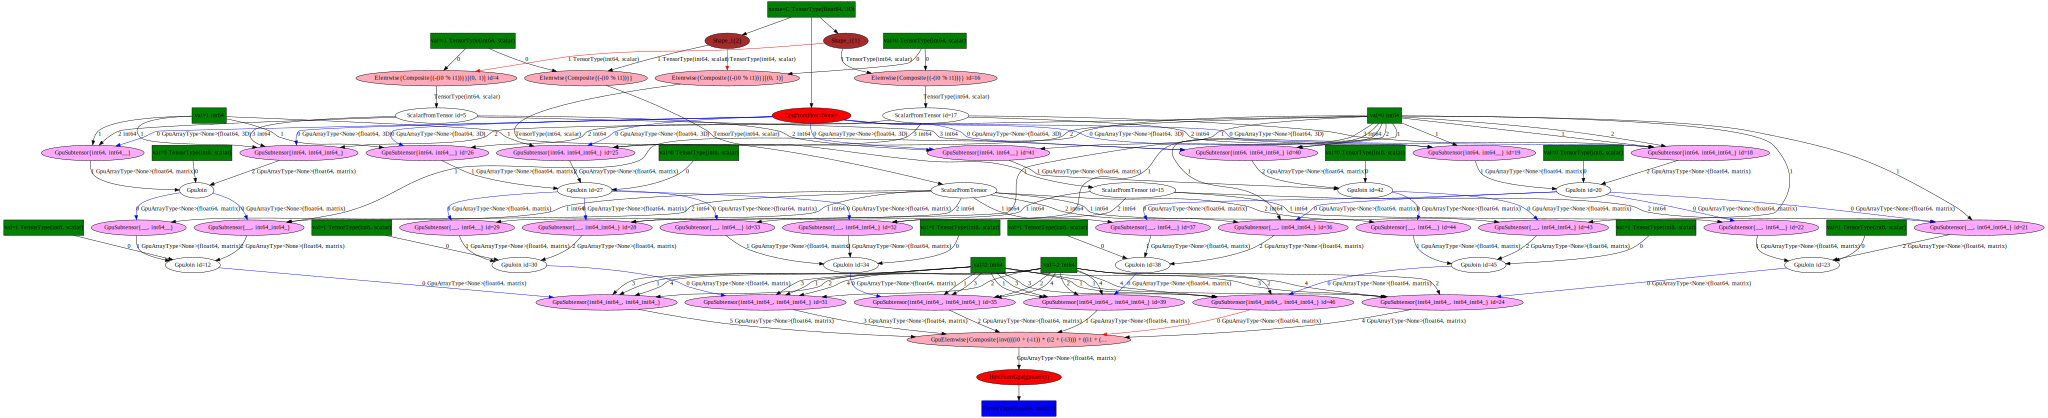

In [66]:
Db=fun(C)(debound(clone(theano_code(Ds[ith,jth]),ro2,strict=False)))
D_ = function([C],Db(C))
SVG(pydotprint(D_.maker.fgraph.outputs[0], return_image=True, format='svg'))

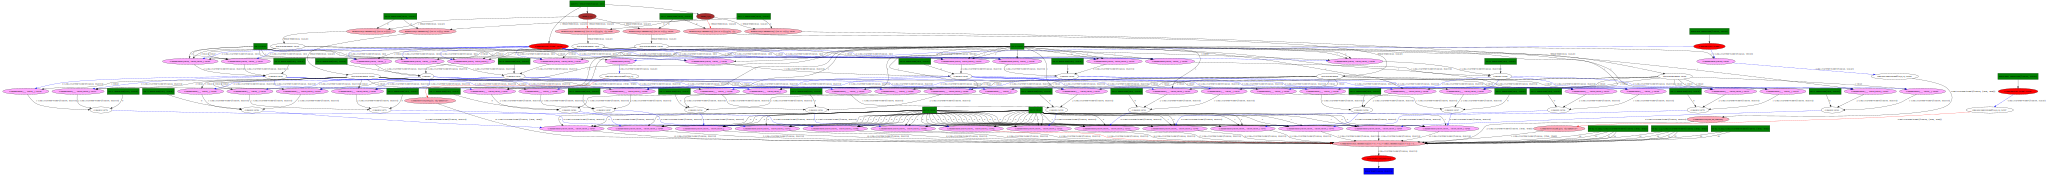

In [67]:
Q2b=fun(hbar_s,mu_v,C)(debound(clone(theano_code(Qs2[ith,jth]),ro2,strict=False)))
Q2b_=function([hbar_s,mu_v,C],Q2b(hbar_s,mu_v,C))
SVG(pydotprint(Q2b_.maker.fgraph.outputs[0], return_image=True, format='svg'))

In [68]:
R0b=fun(hbar_s,mu_v,C)(debound(clone(theano_code(Rs[0,ith,jth]),ro2,strict=False)))
R1b=fun(hbar_s,mu_v,C)(debound(clone(theano_code(Rs[1,ith,jth]),ro2,strict=False)))

In [69]:
def Rb(hbar_s,mu_v,C): return stack([R0b(hbar_s,mu_v,C),R1b(hbar_s,mu_v,C)])
Rb_=function([hbar_s,mu_v,C],Rb(hbar_s,mu_v,C))

### Simulation ###

Using the expressions derived above we can generate efficient numerical functions which we use later in determining the motion of a particle in many worlds simultaneously.

We use the discrete difference approximation to Poirier's equations above for a numerical simulation of quantum motion in a small number of ``parallel'' worlds.

#### Classical Potential ####

In [70]:
x1,y1=scalars('x1','y1')

In [71]:
# Modified Coulomb interaction.
# The constant in the square root makes this continuously differentiable.
V = fun(x1,y1) (-1.0/sqrt((x1-y1)**2+0.000001))

In [72]:
# clone to compile vectorized numeric function
V_ = function([C],V(C[0],C[1]))

In [73]:
testgrid=0.1*(grid(2,500)-0.5)
testgrid.shape

In [74]:
V_(testgrid).shape

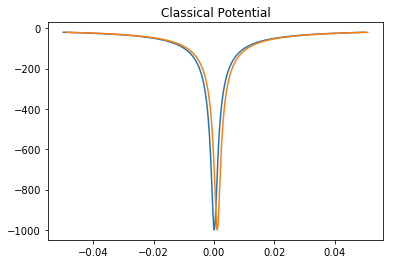

In [75]:
plot(testgrid[0][:,250],V_(testgrid)[:,250])
plot(testgrid[1][250,:]+0.001,V_(testgrid)[250,:])
title('Classical Potential')
show()

#### Classical Force ####

In [76]:
# symbolic gradient
Fx1 = fun(x1,y1) (-grad(V(x1,y1),x1))
Fy1 = fun(x1,y1) (-grad(V(x1,y1),y1))

In [77]:
F_ = function([C],stack([Fx1(C[0],C[1]),Fy1(C[0],C[1])]))

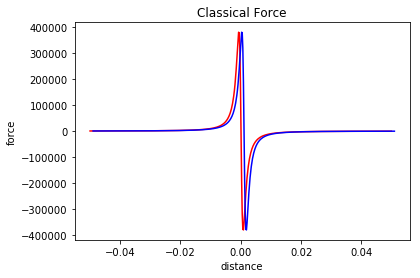

In [78]:
plot(testgrid[0][:,250],F_(testgrid)[0][:,250],
     color='red')
plot(testgrid[1][250,:]+0.001,F_(testgrid)[1][250,:],
     color='blue')
title('Classical Force')
xlabel('distance'); ylabel('force')
show()

### Initial Data ###

We introduce two widely separated fictitious worlds (not subject to dynamics) to the left and right to approximate open boundary conditions.

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ "parallel" worlds.

In [79]:
N = 10

#### Spatial Distribution

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ ``parallel'' worlds. Everything is in atomic units below, so $\hbar=1$.

In [80]:
bx1=2*(arange(0.0+0.5/(N+2*B),1.0,1.0/(N+2*B),config.floatX)-0.5)
bxy=array(meshgrid(bx1,bx1,indexing='ij'))
bxy.shape

In [81]:
xy=array(list(map(debound,bxy))); xy.shape

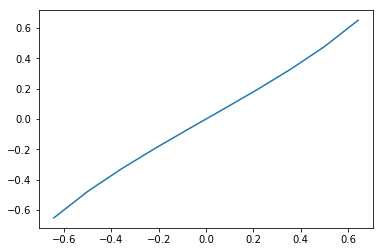

In [82]:
plot(xy[0][:,0],erfinv(xy[0][:,0]).eval()); show()

In [83]:
g1=erfinv(2*(arange(0.0+0.5/(N+2*B),1.0,1.0/(N+2*B),config.floatX)-0.5)).eval()
g1[0] -= 1e12;       g1[1] -= 1e6;       g1[-2] += 1e6;       g1[-1] += 1e12
b0=array(meshgrid(50*g1-50,g1,indexing='ij'))
b0.shape

In [84]:
crosses=fun(C)(min([debound(d(-1,C[j],j)) for j in dim])<0)

In [85]:
crosses(b0).eval()

array(False, dtype=bool)

In [86]:
p0 = array(list(map(debound,b0)))
p0.shape

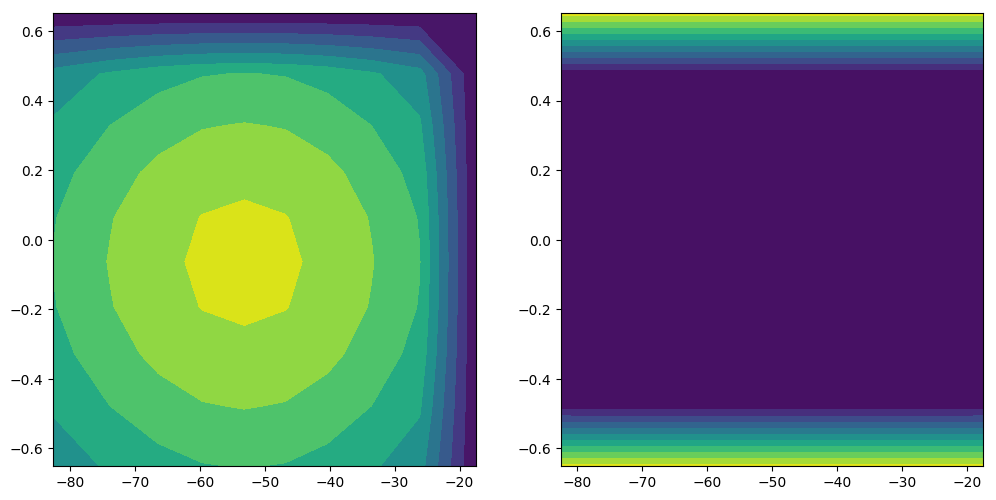

In [87]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.add_subplot(121)
#ax1.set_aspect('equal')
ax1.contourf(p0[0],p0[1],D_(b0),10)
ax2=fig.add_subplot(122)
#ax2.set_aspect('equal')
ax2.contourf(p0[0],p0[1],Q2b_(1,[1,1],b0),10)
show()

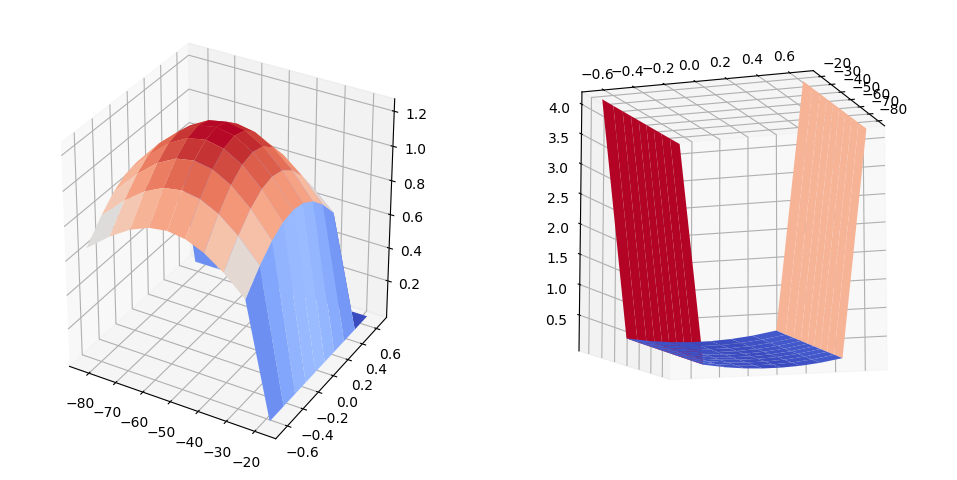

In [88]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
# Plot the surface
ax1.plot_surface(p0[0], p0[1], D_(b0), cmap=coolwarm, linewidth=0, antialiased=True)
#ax1.view_init(10, 30)
ax2.plot_surface(p0[0], p0[1], Q2b_(1,[1,1],b0), cmap=coolwarm, linewidth=0, antialiased=True)
ax2.view_init(-10, 20)
show()

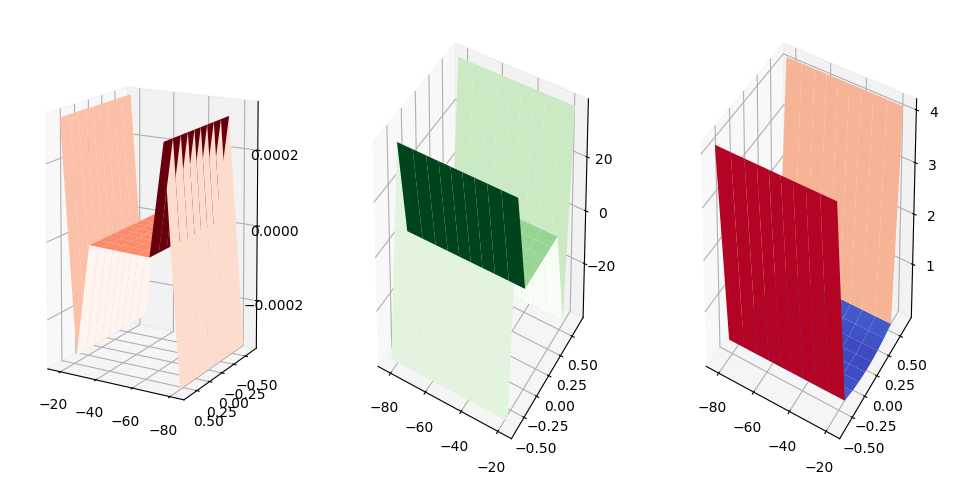

In [89]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
# Plot the surface
ax1.plot_surface(p0[0], p0[1], Rb_(1,[1,1],b0)[0], cmap=Reds, linewidth=0, antialiased=True)
ax1.view_init(10, 120)
ax2.plot_surface(p0[0], p0[1], Rb_(1,[1,1],b0)[1], cmap=Greens, linewidth=0, antialiased=True)
#ax2.view_init(10, 240)
ax3.plot_surface(p0[0], p0[1], Q2b_(1,[1,1],b0), cmap=coolwarm, linewidth=0, antialiased=True)
#ax3.view_init(10, 20)
show()

We will use numeric functions based on the simplified sympy expressions for the quantum potential and force in the following simulation.

#### Distribution of Velocity ####
The electron ensemble approachs the proton ensemble with the same initial velocity in each world.

In [90]:
#v0=full(b0.shape,0.0,config.floatX)
#v0=array(meshgrid(array([1.0 for i in range(N+2*B)],config.floatX),array([0.0 for i in range(N+2*B)],config.floatX)))
v0=array(meshgrid(array([0.001 for i in range(N+2*B)],config.floatX),array([0.0 for i in range(N+2*B)],config.floatX)))


#### Acceleration ####

In [91]:
def boundary2(s): return stack([boundary0(s[i]) for i in dim])

In [92]:
def debound2(s): return stack([debound(s[i]) for i in dim])

In [93]:
def F(C): return stack([
            Fx1(C[0],C[1]),
            Fy1(C[0],C[1])])

In [94]:
def A(hbar,mu,x):
    return shape_padright(1/mu,2)*boundary2(F(debound2(x)) + Rb(hbar,mu,x))

#### Step Size Controller ####
Continuous integrating step size controller \cite{hairer2005}

In [95]:
def G(a,v):
    alpha = -60.0 # sensitivity
    eps = 1e-12
    g1 = sum(a*v)
    g2 = sum(v**2)
    #print g1.eval(),g2.eval()
    return switch(eq(g2,0),1/eps,-alpha*g1/g2)

#### Integration ####
Integrate using the Störmer–Verlet algorithm with adaptive step size.

In [96]:
mu = array([1.0,1836.0])  # mass
hbar = 1.0 # Planck's constant
rho = shared(asarray(1.0, config.floatX),'rho')
ds = scalar('ds')
dt = ds/rho
t = shared(asarray(0.0, config.floatX),'t')
x = shared(b0,'x')

In [97]:
a0 = A(hbar,mu,x).eval()

In [98]:
a = shared(a0,'a')
v = shared(v0,'v')
x_new = x+v*dt+0.5*a*dt**2
a_new = A(hbar,mu,x_new)
v_new = v+0.5*a*dt+0.5*a_new*dt

In [99]:
VerletStep = function([ds],t, updates=[
    (rho, rho + G(a_new,v_new)*dt ),
    (x, x_new ),
    (v, v_new ),
    (a, a_new ),
    (t, t + dt)
],allow_input_downcast=True)

#### Energy ####

In [100]:
KU1 = 0.5*sum(add([mu[j]*v[j]**2 for j in dim]))  # total kinetic energy
PU1 = sum(debound(V(x[0],x[1])))             # total classical potential
QU1 = sum(Q2b(hbar,mu,x))            # total quantum potential

In [101]:
E_ = function([],[KU1,PU1,QU1])

In [102]:
E_()

[array(9.8e-05), array(-2.477825178787869), array(0.08148588600640526)]

In [103]:
crosses_=function([],crosses(x))

In [104]:
crosses_()

array(False, dtype=bool)

In [105]:
t_start = 0.0; t_end = 100.0;
t_samples = 200; x_samples = N;

t_sample = t_end/t_samples
x_sample = __builtin__.max(1,int(N)//int(x_samples))
x_start = __builtin__.max(0,int(N-x_samples*x_sample)//int(2))
XS = array(range(B+x_start,B+N-x_start,x_sample))
#ds0 = 0.0001 # N=10 # initial step size
ds0 = 0.25e-02 # N=10 # initial step size
#ds0 = 2.5e-06 # N=20 # initial step size
dsn = 1 # initial step size divider

In [106]:
while True:
    try: # step size
        ds = ds0/dsn
        # initial values
        rho0 = 1.0
        rho.set_value(rho0)
        t.set_value(t_start)
        x.set_value(b0)
        v.set_value(v0)
        a.set_value(a0)
        # recording
        T = [t_start]
        Rho = select({t_start:rho.get_value().item()})
        XX = select({t_start:x.get_value()[:,XS][:,:,XS]})
        XV = select({t_start:v.get_value()[:,XS][:,:,XS]})
        [KK,PP,QQ] = E_()
        E1 = KK+PP+QQ  # total energy
        TK = select({t_start:KK})
        TP = select({t_start:PP})
        TQ = select({t_start:QQ})
        E = select({t_start:E1})
        try:
            t0 = t.get_value().item()
            while t0<t_end:
                t1 = t0 + t_sample
                while t0<t1:
                    rho0 = rho.get_value().item()
                    if rho0 > 10000 or rho0 < 0.01:
                        raise ValueError("Step control failed at %s. rho=%s"%(t0,rho0))
                    t0 = VerletStep(ds).item()
                if crosses_(): raise ValueError("crossing at %s",t0)
                # Check total energy conservation
                [KK,PP,QQ] = E_()
                E2 = KK+PP+QQ
                if abs(E1-E2)>0.01:
                    raise ValueError(
                        "Energy conservation bound failed at %s. Delta E:"\
                        "|%s| > 0.01."%(t0,E1-E2))
                print "t =", t0, "t1 =",t1,"rho =", rho0, "delta E =",E1-E2
                sys.stdout.flush()
                E1 = E2
                T += [t0]
                XX[t0] = x.get_value()[:,XS][:,:,XS]
                XV[t0] = v.get_value()[:,XS][:,:,XS]
                Rho[t0] = rho.get_value().item()
                TK[t0] = KK; TP[t0] = PP; TQ[t0] = QQ; E[t0] = E1
                t0 = t.get_value().item()
        except KeyboardInterrupt:
            print "Interrupted at %s ..."%(t0)
            T += [t0]
            XX[t0] = x.get_value()[:,XS][:,:,XS]
            XV[t0] = v.get_value()[:,XS][:,:,XS]
            Rho[t0] = rho.get_value().item(); TK[t0] = KK; TP[t0] = PP; TQ[t0] = QQ; E[t0] = E1
        tmax = t0
        break
    except ValueError as msg:
        print msg
        tmax = t0
        #break
        dsn = dsn + 1
        print "Trying a shorter initial step size: %s."%(ds0/dsn)
        continue
T=array(T)
print "t =", tmax

t = 0.500131719717 t1 = 0.5 rho = 15.3118435534 delta E = -5.10702591328e-14


t = 1.00036158671 t1 = 1.00029499202 rho = 30.1099915476 delta E = -7.27862214944e-13


t = 1.50044835648 t1 = 1.50044461563 rho = 43.1993986676 delta E = -3.17346149359e-12


t = 2.0005340758 t1 = 2.00050622765 rho = 54.4622616251 delta E = -8.65352234314e-12


t = 2.50060526811 t1 = 2.50057997914 rho = 64.1934968879 delta E = -1.85615967041e-11


t = 3.00066366706 t1 = 3.00064421287 rho = 72.6994388761 delta E = -3.44062556223e-11


t = 3.50072370007 t1 = 3.50069805522 rho = 80.2268544818 delta E = -5.81028558599e-11


t = 4.00075765651 t1 = 4.0007548617 rho = 86.9635576663 delta E = -9.15409970048e-11


t = 4.50080187853 t1 = 4.50078640418 rho = 93.052922258 delta E = -1.37357680785e-10


t = 5.00083141743 t1 = 5.00082874497 rho = 98.6040898355 delta E = -1.97897698229e-10


t = 5.50086699881 t1 = 5.50085677134 rho = 103.702312813 delta E = -2.76515699227e-10


t = 6.00089972582 t1 = 6.00089110627 rho = 108.414507616 delta E = -3.77470055213e-10


t = 6.50094443162 t1 = 6.50092278547 rho = 112.794391065 delta E = -5.03566521814e-10


t = 7.00097840985 t1 = 7.00096659585 rho = 116.885188242 delta E = -6.59429844063e-10


t = 7.50100535197 t1 = 7.50099979836 rho = 120.722567491 delta E = -8.5212992218e-10


t = 8.00103858121 t1 = 8.00102606061 rho = 124.33618256 delta E = -1.08567421719e-09


t = 8.50106226942 t1 = 8.50105868799 rho = 127.750684132 delta E = -1.36658018235e-09


t = 9.0010897466 t1 = 9.00108183879 rho = 130.987109957 delta E = -1.70202696381e-09


t = 9.50111682355 t1 = 9.50110883245 rho = 134.063293028 delta E = -2.09855288702e-09


t = 10.0011522297 t1 = 10.0011354715 rho = 136.994634656 delta E = -2.56644439034e-09


t = 10.5011707787 t1 = 10.5011704786 rho = 139.794276259 delta E = -3.11429593225e-09


t = 11.001193427 t1 = 11.0011886621 rho = 142.473912107 delta E = -3.74975872575e-09


t = 11.5012194504 t1 = 11.5012109741 rho = 145.043674923 delta E = -4.4851811154e-09


t = 12.0012498202 t1 = 12.0012366866 rho = 147.512499899 delta E = -5.33076560671e-09


t = 12.5012740919 t1 = 12.5012667679 rho = 149.888245258 delta E = -6.29872243252e-09


t = 13.0012908042 t1 = 13.001290771 rho = 152.177943592 delta E = -7.40145145173e-09


t = 13.5013094023 t1 = 13.5013072324 rho = 154.387925727 delta E = -8.65092575353e-09


t = 14.0013357424 t1 = 14.0013255953 rho = 156.523854648 delta E = -1.00618646748e-08


t = 14.5013585055 t1 = 14.5013517144 rho = 158.590759398 delta E = -1.16479026424e-08


t = 15.0013830577 t1 = 15.0013742694 rho = 160.593251887 delta E = -1.34239885874e-08


t = 15.5014010543 t1 = 15.501398625 rho = 162.535460828 delta E = -1.5406581344e-08


t = 16.0014228761 t1 = 16.0014164355 rho = 164.421212013 delta E = -1.76121339734e-08


t = 16.5014475593 t1 = 16.5014380809 rho = 166.25395367 delta E = -2.00570324793e-08


t = 17.0014643595 t1 = 17.0014625966 rho = 168.036806067 delta E = -2.27587775292e-08


t = 17.5014835162 t1 = 17.5014792372 rho = 169.772704023 delta E = -2.57349399568e-08


t = 18.0015067488 t1 = 18.0014982418 rho = 171.46431707 delta E = -2.90026966887e-08


t = 18.5015283254 t1 = 18.5015213291 rho = 173.114081524 delta E = -3.25806355228e-08


t = 19.0015502831 t1 = 19.0015427667 rho = 174.72427331 delta E = -3.64883274706e-08


t = 19.5015683912 t1 = 19.5015645914 rho = 176.296980031 delta E = -4.07450695405e-08


t = 20.0015869336 t1 = 20.0015825718 rho = 177.834164662 delta E = -4.53708395298e-08


t = 20.5016048062 t1 = 20.5016009917 rho = 179.3376358 delta E = -5.03846351307e-08


t = 21.0016299314 t1 = 21.0016187463 rho = 180.809104328 delta E = -5.58074120249e-08


t = 21.5016517903 t1 = 21.5016437581 rho = 182.250113752 delta E = -6.16570865475e-08


t = 22.0016696608 t1 = 22.0016655077 rho = 183.662134734 delta E = -6.79546858784e-08


t = 22.5016925002 t1 = 22.5016832728 rho = 185.046570877 delta E = -7.47213770858e-08


t = 23.0017120086 t1 = 23.0017060103 rho = 186.404691836 delta E = -8.19750858305e-08


t = 23.5017301053 t1 = 23.5017254203 rho = 187.737717585 delta E = -8.97368388486e-08


t = 24.001745538 t1 = 24.0017434217 rho = 189.046787605 delta E = -9.80255272509e-08


t = 24.5017673087 t1 = 24.5017587623 rho = 190.333001733 delta E = -1.06863472737e-07


t = 25.0017884025 t1 = 25.0017804436 rho = 191.597357365 delta E = -1.16267110162e-07


t = 25.5018123932 t1 = 25.5018014507 rho = 192.840823313 delta E = -1.26256025634e-07


t = 26.0018274758 t1 = 26.0018253572 rho = 194.064278905 delta E = -1.36843714582e-07


t = 26.50184548 t1 = 26.5018403581 rho = 195.268614109 delta E = -1.48055427918e-07


t = 27.0018630851 t1 = 27.0018582828 rho = 196.45463739 delta E = -1.59903818631e-07


t = 27.5018876873 t1 = 27.5018758107 rho = 197.623141774 delta E = -1.72409939658e-07


t = 28.0019120305 t1 = 28.0019003377 rho = 198.77484801 delta E = -1.85585030898e-07


t = 28.5019272252 t1 = 28.5019246075 rho = 199.91043908 delta E = -1.99442392379e-07


t = 29.0019477443 t1 = 29.0019397308 rho = 201.030618481 delta E = -2.14006611987e-07


t = 29.5019613834 t1 = 29.5019601802 rho = 202.13599914 delta E = -2.29280338715e-07


t = 30.0019792656 t1 = 30.0019737513 rho = 203.227217853 delta E = -2.45286645661e-07


t = 30.501998574 t1 = 30.5019915671 rho = 204.304854185 delta E = -2.62031877085e-07


t = 31.0020151553 t1 = 31.0020108106 rho = 205.369460849 delta E = -2.79526195968e-07


t = 31.5020357197 t1 = 31.5020273284 rho = 206.421591051 delta E = -2.97785312853e-07


t = 32.0020535184 t1 = 32.0020478308 rho = 207.46174841 delta E = -3.16811367362e-07


t = 32.5020727099 t1 = 32.5020655688 rho = 208.490439849 delta E = -3.36618363406e-07


t = 33.0020962039 t1 = 33.0020847009 rho = 209.508151088 delta E = -3.57213691959e-07


t = 33.5021138598 t1 = 33.5021081366 rho = 210.515324428 delta E = -3.78592406758e-07


t = 34.0021264739 t1 = 34.0021257354 rho = 211.512408834 delta E = -4.00766889008e-07


t = 34.5021455563 t1 = 34.5021382935 rho = 212.499859489 delta E = -4.23750210921e-07


t = 35.0021579873 t1 = 35.002157321 rho = 213.478069043 delta E = -4.4752370032e-07


t = 35.5021732404 t1 = 35.5021696981 rho = 214.447461959 delta E = -4.72108083294e-07


t = 36.0021880849 t1 = 36.0021848983 rho = 215.408425924 delta E = -4.97490782347e-07


t = 36.5022100044 t1 = 36.5021996908 rho = 216.361358251 delta E = -5.23682357922e-07


t = 37.0022224735 t1 = 37.0022215591 rho = 217.306600494 delta E = -5.50654095655e-07


t = 37.5022427739 t1 = 37.502233978 rho = 218.244549054 delta E = -5.78437438392e-07


t = 38.002264259 t1 = 38.0022542289 rho = 219.17554642 delta E = -6.07001469977e-07


t = 38.5022795976 t1 = 38.5022756654 rho = 220.099926379 delta E = -6.36336058957e-07


t = 39.0022921143 t1 = 39.0022909561 rho = 221.018035462 delta E = -6.66447813824e-07


t = 39.5023043187 t1 = 39.5023034256 rho = 221.930212106 delta E = -6.97324819221e-07


t = 40.002317937 t1 = 40.0023155835 rho = 222.836787425 delta E = -7.28956187412e-07


t = 40.5023339402 t1 = 40.502329156 rho = 223.738085964 delta E = -7.61328945664e-07


t = 41.0023525706 t1 = 41.002345114 rho = 224.634426415 delta E = -7.94428283601e-07


t = 41.5023733658 t1 = 41.5023636998 rho = 225.526122315 delta E = -8.28237050499e-07


t = 42.00239518 t1 = 42.002384451 rho = 226.41348272 delta E = -8.62738906093e-07


t = 42.5024162044 t1 = 42.5024062218 rho = 227.296812869 delta E = -8.97914682163e-07


t = 43.0024339844 t1 = 43.0024272033 rho = 228.176414827 delta E = -9.33743683262e-07


t = 43.502445436 t1 = 43.5024449409 rho = 229.05258813 delta E = -9.70203927864e-07


t = 44.0024577327 t1 = 44.0024563505 rho = 229.925649367 delta E = -1.00729390295e-06


t = 44.5024772816 t1 = 44.5024686058 rho = 230.79591335 delta E = -1.04499183085e-06


t = 45.0024881547 t1 = 45.0024881137 rho = 231.66365641 delta E = -1.08322703385e-06


t = 45.5025062611 t1 = 45.5024989462 rho = 232.529211208 delta E = -1.12204283065e-06


t = 46.0025251956 t1 = 46.0025170124 rho = 233.392873288 delta E = -1.16136512807e-06


t = 46.5025379907 t1 = 46.5025359071 rho = 234.254939652 delta E = -1.2011639372e-06


t = 47.0025583868 t1 = 47.0025486628 rho = 235.115746025 delta E = -1.24146202651e-06


t = 47.5025780702 t1 = 47.5025690198 rho = 235.975593877 delta E = -1.28217792161e-06


t = 48.0025987324 t1 = 48.0025886645 rho = 236.834806466 delta E = -1.32330562241e-06


t = 48.5026108435 t1 = 48.5026092883 rho = 237.693693121 delta E = -1.36478510626e-06


t = 49.0026252813 t1 = 49.0026213612 rho = 238.552604437 delta E = -1.4066397247e-06


t = 49.502641625 t1 = 49.5026357612 rho = 239.411878727 delta E = -1.44880848962e-06


t = 50.0026587459 t1 = 50.0026520673 rho = 240.271861205 delta E = -1.49125707605e-06


t = 50.5026748021 t1 = 50.5026691508 rho = 241.132905009 delta E = -1.5339490993e-06


t = 51.0026872315 t1 = 51.0026851698 rho = 241.995372311 delta E = -1.57684895585e-06


t = 51.5027030359 t1 = 51.5026975623 rho = 242.859653303 delta E = -1.61995262404e-06


t = 52.0027180718 t1 = 52.0027133299 rho = 243.726131798 delta E = -1.66319157868e-06


t = 52.5027376617 t1 = 52.5027283292 rho = 244.595222306 delta E = -1.70656258991e-06


t = 53.0027560265 t1 = 53.0027478827 rho = 245.467335948 delta E = -1.74999296032e-06


t = 53.5027665964 t1 = 53.5027662111 rho = 246.342899925 delta E = -1.79344317219e-06


t = 54.0027822133 t1 = 54.0027767449 rho = 247.222394968 delta E = -1.83694869094e-06


t = 54.5027944392 t1 = 54.5027923257 rho = 248.106286169 delta E = -1.8803988735e-06


t = 55.0028140491 t1 = 55.0028045155 rho = 248.995096546 delta E = -1.92383032482e-06


t = 55.5028306212 t1 = 55.5028240895 rho = 249.889338164 delta E = -1.96712807332e-06


t = 56.0028427638 t1 = 56.0028406256 rho = 250.78956846 delta E = -2.01029166913e-06


t = 56.5028578941 t1 = 56.5028527324 rho = 251.696393616 delta E = -2.05332404857e-06


t = 57.0028722168 t1 = 57.0028678267 rho = 252.610436147 delta E = -2.09614721092e-06


t = 57.5028905714 t1 = 57.5028821135 rho = 253.532374999 delta E = -2.13876537192e-06


t = 58.0029065419 t1 = 58.0029004321 rho = 254.462913818 delta E = -2.18109919281e-06


t = 58.5029221447 t1 = 58.5029163665 rho = 255.402822518 delta E = -2.22315323217e-06


t = 59.002937818 t1 = 59.0029319331 rho = 256.352925126 delta E = -2.26489248867e-06


t = 59.5029523328 t1 = 59.5029475702 rho = 257.314106559 delta E = -2.30628146447e-06


t = 60.0029626923 t1 = 60.0029620485 rho = 258.287320441 delta E = -2.34728442638e-06


t = 60.5029736603 t1 = 60.5029723714 rho = 259.273617291 delta E = -2.38791241625e-06


t = 61.0029878405 t1 = 61.0029833026 rho = 260.274136741 delta E = -2.428133139e-06


t = 61.5030055261 t1 = 61.5029974457 rho = 261.290120066 delta E = -2.46791468816e-06


t = 62.0030245273 t1 = 62.0030150941 rho = 262.322924961 delta E = -2.50722460349e-06


t = 62.5030399724 t1 = 62.5030340576 rho = 263.374043055 delta E = -2.54603150385e-06


t = 63.0030535327 t1 = 63.0030494646 rho = 264.445141294 delta E = -2.58435360223e-06


t = 63.5030635483 t1 = 63.5030629865 rho = 265.538068066 delta E = -2.62216247915e-06


t = 64.0030740881 t1 = 64.0030729631 rho = 266.654905346 delta E = -2.65948005662e-06


t = 64.503085046 t1 = 64.5030834635 rho = 267.797987163 delta E = -2.69628088034e-06


t = 65.0031009928 t1 = 65.0030943814 rho = 268.96996913 delta E = -2.73259047479e-06


t = 65.5031119357 t1 = 65.5031102875 rho = 270.173845323 delta E = -2.7683351651e-06


t = 66.0031297318 t1 = 66.003121189 rho = 271.413114086 delta E = -2.80364615612e-06


t = 66.5031408323 t1 = 66.5031389429 rho = 272.691765757 delta E = -2.83839901316e-06


t = 67.0031513665 t1 = 67.0031500001 rho = 274.014527456 delta E = -2.87273238442e-06


t = 67.5031671147 t1 = 67.5031604901 rho = 275.386994897 delta E = -2.90668200975e-06


t = 68.0031826988 t1 = 68.0031761928 rho = 276.815845209 delta E = -2.94023384884e-06


t = 68.5031975503 t1 = 68.5031917301 rho = 278.309219167 delta E = -2.97348219735e-06


t = 69.0032127862 t1 = 69.0032065331 rho = 279.877201584 delta E = -3.00652441032e-06


t = 69.5032271207 t1 = 69.5032217187 rho = 281.532530793 delta E = -3.03946305236e-06


t = 70.0032401564 t1 = 70.0032360006 rho = 283.291719391 delta E = -3.07246068099e-06


t = 70.503253074 t1 = 70.5032489813 rho = 285.176849874 delta E = -3.10574031914e-06


t = 71.0032651794 t1 = 71.0032618405 rho = 287.218626414 delta E = -3.13959141574e-06


t = 71.5032806287 t1 = 71.5032738836 rho = 289.462044103 delta E = -3.17448275045e-06


t = 72.003292346 t1 = 72.0032892654 rho = 291.977761129 delta E = -3.21101710821e-06


t = 72.5033045937 t1 = 72.5033009083 rho = 294.888735933 delta E = -3.25038973648e-06


t = 73.0033195792 t1 = 73.0033130714 rho = 298.44505264 delta E = -3.29469495419e-06


t = 73.5033346001 t1 = 73.503327956 rho = 303.316109615 delta E = -3.34874917174e-06


t = 74.003343705 t1 = 74.0033428424 rho = 312.914733479 delta E = -3.43007076387e-06


t = 74.5033564437 t1 = 74.5033516944 rho = 318.250374898 delta E = -0.000178807183316


t = 75.0033655649 t1 = 75.0033642991 rho = 314.785282765 delta E = -3.47952282453e-06


t = 75.5033743449 t1 = 75.5033735068 rho = 337.16356522 delta E = -3.59564216623e-06


t = 76.0033886029 t1 = 76.0033817597 rho = 320.594855215 delta E = -0.000176734694518


t = 76.5033977056 t1 = 76.5033964009 rho = 349.264457351 delta E = -0.000176432995941


t = 77.0034060571 t1 = 77.0034048635 rho = 323.743944571 delta E = -3.24907355287e-06


t = 77.5034168316 t1 = 77.5034137792 rho = 328.951129102 delta E = -0.000174782228975


t = 78.0034306893 t1 = 78.0034244315 rho = 327.994697061 delta E = -3.28577859454e-06


t = 78.5034414079 t1 = 78.5034383114 rho = 325.721148163 delta E = -0.000174661715041


t = 79.003449376 t1 = 79.0034490832 rho = 351.646748517 delta E = -3.39749202949e-06


t = 79.5034584878 t1 = 79.5034564854 rho = 325.09816216 delta E = -0.000174824842989


t = 80.0034710092 t1 = 80.0034661778 rho = 330.692637659 delta E = -0.00017418431149


t = 80.5034811237 t1 = 80.5034785691 rho = 325.713294988 delta E = -3.49043020753e-06


t = 81.003494898 t1 = 81.0034887991 rho = 324.487424483 delta E = -0.000174155748956


t = 81.5035068776 t1 = 81.5035026025 rho = 325.421262314 delta E = -3.67027348958e-06


t = 82.0035189738 t1 = 82.00351456 rho = 319.90497685 delta E = -0.000174713519542


t = 82.5035286087 t1 = 82.5035267886 rho = 315.738001876 delta E = -3.55892277959e-06


t = 83.0035370656 t1 = 83.0035365266 rho = 379.291918049 delta E = -0.000180883970301


t = 83.5035477294 t1 = 83.5035436568 rho = 309.991033345 delta E = 3.33121688767e-06


t = 84.0035604015 t1 = 84.0035557942 rho = 303.614770563 delta E = -3.21054922114e-06


t = 84.5035720392 t1 = 84.5035686357 rho = 299.638087274 delta E = -3.08963811246e-06


t = 85.003587696 t1 = 85.0035803826 rho = 296.592196918 delta E = -3.0070040542e-06


t = 85.5035980056 t1 = 85.503596125 rho = 294.06320054 delta E = -2.94219594155e-06


t = 86.0036068448 t1 = 86.0036065072 rho = 291.87355729 delta E = -2.88792639536e-06


t = 86.5036176744 t1 = 86.5036154102 rho = 289.929187529 delta E = -2.84062425004e-06


t = 87.0036308874 t1 = 87.0036262971 rho = 288.173401493 delta E = -2.79826013472e-06


t = 87.503639922 t1 = 87.5036395628 rho = 286.568980861 delta E = -2.75954869844e-06


t = 88.00364887 t1 = 88.0036486459 rho = 285.089898375 delta E = -2.7237257525e-06


t = 88.5036658974 t1 = 88.5036576392 rho = 283.717112072 delta E = -2.69024407862e-06


t = 89.0036755332 t1 = 89.003674709 rho = 282.436256939 delta E = -2.65856979631e-06


t = 89.503684648 t1 = 89.5036843848 rho = 281.236090041 delta E = -2.62852599819e-06


t = 90.0037002764 t1 = 90.0036935373 rho = 280.107652666 delta E = -2.59988964446e-06


t = 90.5037171287 t1 = 90.5037092015 rho = 279.043697151 delta E = -2.57242776414e-06


t = 91.0037327017 t1 = 91.0037260879 rho = 278.038239887 delta E = -2.54602732586e-06


t = 91.5037453176 t1 = 91.5037416933 rho = 277.086277533 delta E = -2.52059469874e-06


t = 92.0037616144 t1 = 92.00375434 rho = 276.183564637 delta E = -2.49609465763e-06


t = 92.5037772618 t1 = 92.5037706663 rho = 275.326494121 delta E = -2.47241339091e-06


t = 93.0037939889 t1 = 93.0037863419 rho = 274.511947817 delta E = -2.44953578221e-06


t = 93.503809716 t1 = 93.5038030959 rho = 273.737223663 delta E = -2.42740696743e-06


t = 94.003826975 t1 = 94.0038188488 rho = 272.99995166 delta E = -2.40602400003e-06


t = 94.5038432208 t1 = 94.5038361325 rho = 272.298053095 delta E = -2.38534137686e-06


t = 95.0038594891 t1 = 95.0038524019 rho = 271.629682895 delta E = -2.36536120513e-06


t = 95.5038708102 t1 = 95.5038686928 rho = 270.993206649 delta E = -2.34604439475e-06


t = 96.0038842853 t1 = 96.0038800355 rho = 270.387147931 delta E = -2.32744030804e-06


t = 96.5039003912 t1 = 96.5038935313 rho = 269.810188605 delta E = -2.30950976787e-06


t = 97.003912647 t1 = 97.0039096569 rho = 269.261147001 delta E = -2.29221948578e-06


t = 97.5039259288 t1 = 97.5039219317 rho = 268.738940525 delta E = -2.27561783239e-06


t = 98.0039377452 t1 = 98.0039352315 rho = 268.24259254 delta E = -2.25966954082e-06


t = 98.5039473335 t1 = 98.5039470651 rho = 267.771210033 delta E = -2.24438184349e-06


t = 99.0039648778 t1 = 99.0039566698 rho = 267.323965741 delta E = -2.22980292186e-06


t = 99.5039833636 t1 = 99.5039742298 rho = 266.900115069 delta E = -2.21585365345e-06


t = 100.003997083 t1 = 100.00399273 rho = 266.49897007 delta E = -2.20254120409e-06


t = 100.004006464


Step Density

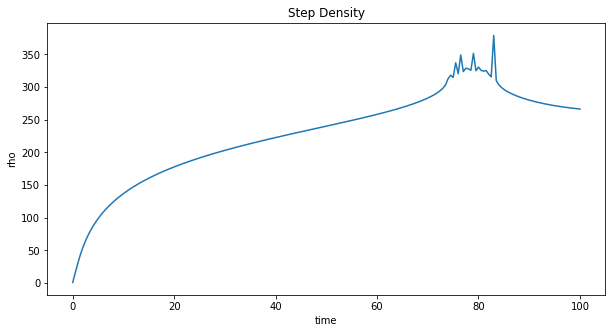

In [107]:
figure(figsize=(10,5))
plot(T, Rho[T])
title('Step Density')
xlabel('time'); ylabel('rho')
show()

#### Quantum Potential, Classical Potential and Kinetic Energy ####

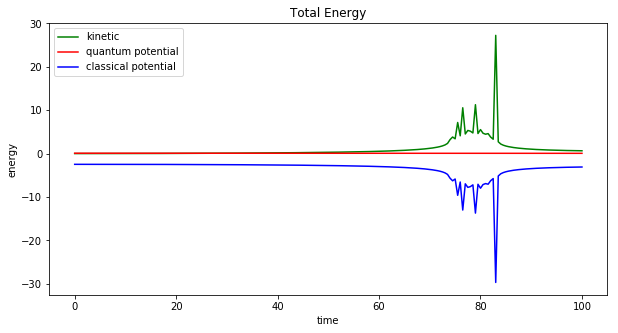

In [108]:
figure(figsize=(10,5))
plot(T, TK[T],color='green',label='kinetic')
plot(T, TQ[T],color='red',label='quantum potential')
plot(T, TP[T],color='blue',label='classical potential')
legend()
title('Total Energy')
xlabel('time'); ylabel('energy')
show()

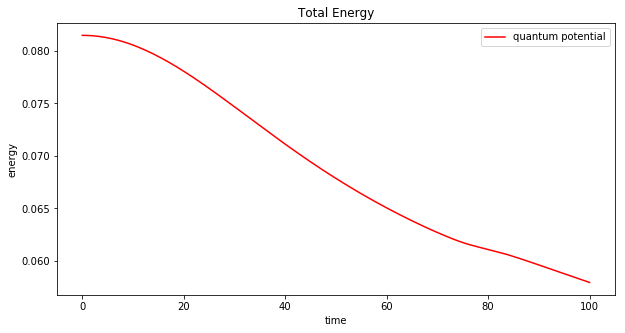

In [109]:
figure(figsize=(10,5))
plot(T, TQ[T],color='red',label='quantum potential')
legend()
title('Total Energy')
xlabel('time'); ylabel('energy')
show()

#### Energy Conservation ####

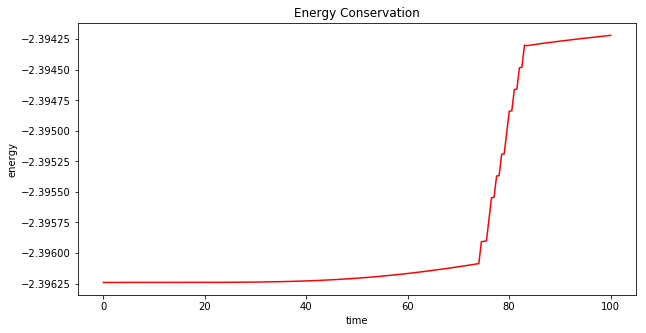

In [110]:
figure(figsize=(10,5))
plot(T, TK[T]+TP[T]+TQ[T],color='red')
title('Energy Conservation')
xlabel('time'); ylabel('energy')
show()

#### Trajectories ####
The trajectory of the particle in each world is shown below.  Notice how the trajectories do not cross, yet in some worlds the particle is scattered from the barrier while in others the particle tunnels across the barrier "pushed" by its counterpart in other worlds.

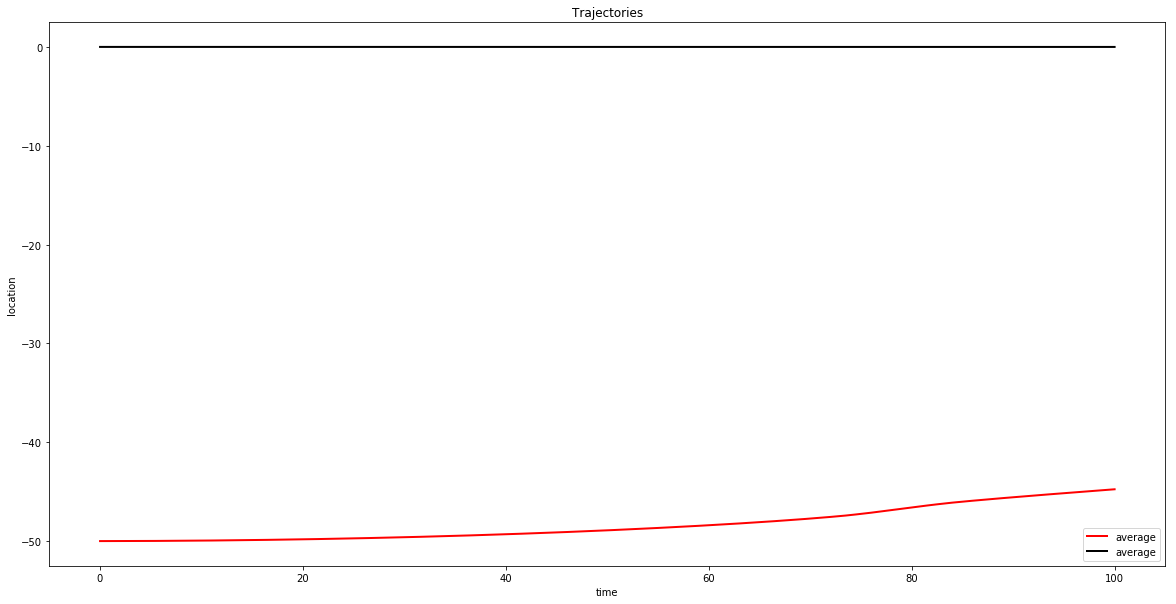

In [111]:
figure(figsize=(20,10))
plot(T, mean(XX[T][:,0],(1,2)), color='red',label='average',linewidth=2)
plot(T, mean(XX[T][:,1],(1,2)), color='black',label='average',linewidth=2)
legend()
title('Trajectories')
xlabel('time'); ylabel('location')
show()

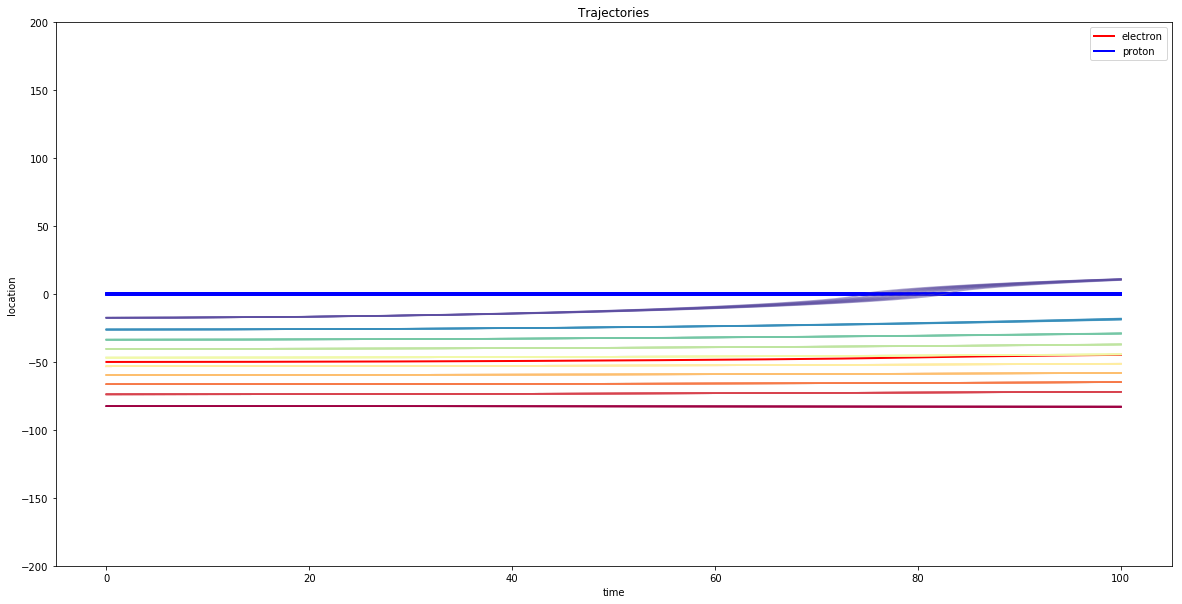

In [112]:
figure(figsize=(20,10))
plot(T, mean(XX[T][:,0],(1,2)), color='red',label='electron',linewidth=2)
plot(T, mean(XX[T][:,1],(1,2)), color='blue',label='proton',linewidth=2)
line_color = Spectral(linspace(0,1,len(XS)))
for i in range(len(XS)):
    for j in range(len(XS)):
        plot(T, XX[T][:,0,i,j],color=line_color[i],alpha=0.5)
        plot(T, XX[T][:,1,i,j],color='blue',alpha=0.5)
legend()
title('Trajectories')
xlabel('time'); ylabel('location')
#xlim(7750,8750)
ylim(-200,200)
show()

This picture reminds me of how cold anti-electrons and anti-protons must be in order to form anti-hydrogen.

Average velocity

In [113]:
mean(v.get_value()[0],(0,1))

In [114]:
from theano.tensor import min,max

In [115]:
min(v.get_value()[0],(0,1)).eval(),max(v.get_value()[0],(0,1)).eval()

(array(-0.01264780397840989), array(0.3179758356170764))

#### Final Distribution ####
The distribution at the end of the simulation shows the reflected and transmitted "wave packets" separating from each other.

In greater detail ...

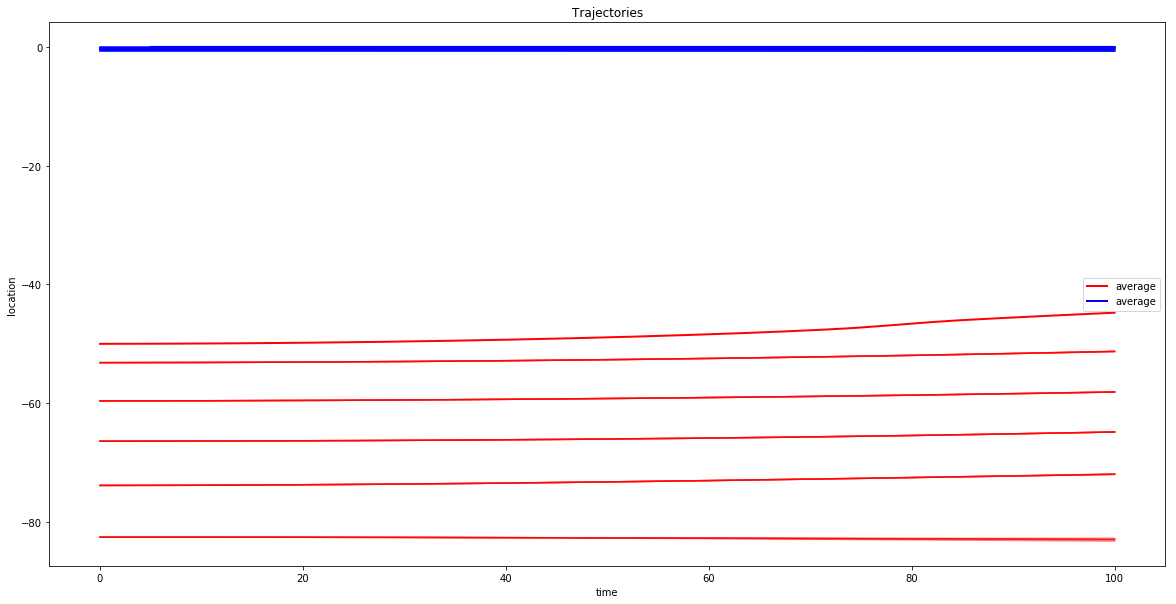

In [116]:
figure(figsize=(20,10))
plot(T, mean(XX[T][:,0],(1,2)), color='red',label='average',linewidth=2)
plot(T[10:], mean(XX[T[10:]][:,1],(1,2)), color='blue',label='average',linewidth=2)
line_color = Spectral(linspace(0,1,len(XS)))
for i in range(0,5): #range(len(XS)):
    for j in range(0,5): #range(len(XS)):
        plot(T, XX[T][:,0,i,j],color='red',alpha=0.5)
        plot(T, XX[T][:,1,i,j],color='blue',alpha=0.5)
legend()
title('Trajectories')
xlabel('time'); ylabel('location')
show()

In [117]:
def update_graph(t):
    return graph.set_offsets((XX[t][0],XX[t][1]))
fig = figure(figsize=(10,5))
ax = axes()
ax.set_xlim((-100, 100))
ax.set_ylim((-100, 100))
graph = ax.scatter([],[],s=0.5)
xlabel('particle 1 (electron)'); ylabel('particle 2 (proton)')
ani = animation.FuncAnimation(fig, update_graph, frames=T, interval=500)
close()
HTML(ani.to_html5_video())

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABdJm1kYXQAAAKtBgX//6ncRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQ4IHIyNzQ4IDk3ZWFlZjIgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE2IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MiBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNo
PTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFw
bWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAGF1liIQA
F//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAAMA6VSCY3zuANGMtAAAAwBU3oef
il1OKkTmAOWrdhYtZKQ5m2E6H6gaIGsb6bE72pJSozSRBPs0NJgxrCUpOglGc3dTOkpQpUFloy6f
jsWKp5f/DTr971G7x84RuYGg3/DzZCfjCcYsuGuQoVecq4zoRaFJ9bOQCBqUs+gWoo26vfXfAegP
6wWnWp2M4n4LtNSB+san9FMF2G+JjKa/FNr+/AD80KZpnRM7QhVC3mhjm5D3+92NohxA/QoLgvUq
S582BwBf14/ILuFL/NIiefz4bsWtyK/VUUtbT3O4yRl8Aoxx+nxp8ktQbvpoQvwi1Y+p9sUPTcnP
KsGC1KkpkBgEPviL9qarfCLY61Z8N/3GnewAAKAFlGcYZmNtbbStaTaPZl9z8j8uZ83Vt6BUCZuB
ZV13+pEAAKoNlr31WHA+cC7aLzUnOlC2qczcOyq8FZDpN2rqBLaYIDQzol7CacxluWZLY5u9pmAK
1TX+Wu0F6M/nojrY7hERwJPRERdP7JRkWyvvmCJ1BxddwjkaysOsAJrT6MyFatNV/iN+Odz6GmIK
jm0m2i/hUCx9MYgOSCbfrGxbFFNFvIFE1IAD+namqTqIHuR29UnZjfdBgVz94oALkmKKfTtEul/5
zO1HZmotyg4mBK+Ey7Tao4IW+Ib/8IaAO02e6tKElyvoNY75l+Bvg8+b0BsTEUw8ev4wC09Op8/O
UWbwxMNVXB7HQhopidUwsF5tT1LjoHZDH/z/fpBeFJBSItiuicCvYj0PcikKIAUluM3zspcUu/Jo
fAqSlvgZM0pZCPe3Niha0f8oP96YHe2beFnMC0h4AKbfcXD1vV26THckLwJkGeELwxxAjekRQENs
i7Rm+YSm4YKpSN9ElPMvekwPenFJo7jaZ5n8c3X0d1OA9w7NDFem9gf2Wgh0TzdKF+K7ACLoDwU1
j5BulL+wTLTmSroNCRGpO3oRrkbiADyb35Gk1zMlJNqU5BM+yS7cvgTrxG79fxjvZdF8zaTW+UQQ
tkj1O2wncFdQK6FemTFcz/UYAwsaDl+f3YVhe/QGDhxobp6B2TrEKThmq+sn2f8rXkfVh9nsET5r
IufJIYVyx32uiyKAHHW2wj/MXdGBTlHI23C/RNtnfob7Qd3juBqgHLBz+GMWjYuj8D2YRethFl5X
waUfDvCNn2GNXt9iVIAyskOQq2MSkjiM6//M1nIjpzptXyKeE9bitWa4ra9X6Lu0+bBOIlXaV4e9
X+Lrvnl/oAm6TmBFvcAvGDMyzw/6QRyJY/Z+yzDQjxOH8+NAAS/l26JZKCHXHid5yJ3Znkwl4Xm7
hGutJqCZ//I4Mzxvhm/e/tdrfBPN8OtKphLm4gyxNWewXEcLYfnhpHnn5hhyGbBUhaydliU5G+Ue
62zkKhsd+SoD8iVFtGg2I1hEB2c+N0l0qC5SoKVrDcOvhvoT4CLHASzQKCxq36WPOqEC3lLoDSXR
XT4QMNTZcN/mU/7HTZe48GIPN2TDk9zOo1fo50qcK2SazFUOz2DKwpRBgGNObPjg3Ucr6Rt0rr/E
t6UIozEk8MwpQRAkmO5MuQAXkBUkdyC60YqE/lu8DTC0ZbBwuo5ZdW4ySnTtaLB6s/VZg/v33LPX
+ygCJDFB/xnKo7TDKEjHn5rhWa74N3XIKolrqJZ0QiAfv9hj706GUyoZeQc+6et2mEgMVLTU3Pv5
fguOQwKJ+Rht1s9mMABPJ8TUp2qLEx8nZzVheBz2kjQWnJScV3ddziIa0XK8FFA4eQGpnsq33+5e
hiaj0/TyJajctrfAzLq/nPmoNXTBWoC7KxJQ7tmWfMlO6NBkwOOtlwrvkEbE0fYII9SijWrrmLgp
AAWoVZ9GZ4muXFeVw8Su/MiU6LmNyYA7/YOfHjOcGlvCEAGNz5KybPglLXjdphCLLxguz8zV/qm3
XgwNyT2eYbB195X0X/3U7Japqq+zJDTWqc+Yuxjn48Qj7OQCJNMva1rc9MKBaVVZlHCRfioIAK8P
rM8Mv1TPuohtHZdWKyF11doGMGrh7sr6H8BcIuVKASOCpMv2FqP6BAoduw88kLcQt4xUj0zwEttU
8xPrC/LFYlaPm5aTsUr9SDYVTDxbkfCOrkrGNWXesVBPAXw54I3lp3/C9tFvO2XURe3RBVeW+fNX
v+YtmVKW6PpuTpQixUtDsqaCpjWznzU+abMOxFjOGcW44AaPhz01pdv6BJJhDOgoMiFqXNsjSwKY
YSo4C0weyoVVqiNncAgcNVoSVFtDzth2ATOBx9apIgvZoK+tHVg9evKAS9un6HOCf0TsEnKeaQrG
qLzXuD7/7Gb4aiwBJTJyx9WLkHhqdeKxmXVc/HuYSaPtwwMTul8U6+vRAynQd+/TSgHsbdkB17Ek
BF50plRbT27c+NqZjHldHzBQmCvgOlJUY72MTJi9Uv4BDoFXj+ukLRG/p2o3ILqf4zQ+be4xWOfo
s7wiEZi+MgHynArmDceIozWCO5J+oZdE6+lZafMbWd4ClAR1f9Yht8nftGqb2Bz1RXgHnc2/bv9M
0pJelxoZRhPCnu39c/g+Vusw6n7bj/ylMrHomS+kvQN3k9iQzfzMtD4gV+fQZVyUSne1iGS4mXAL
vlnA4zYOJAd6Oz7kYfwmJI67Y++MLj1ZIYT+3azmhopmmur9weAITU3SpK1mIAXfJ7AfLtaDWPU4
y7RnY6gd0U7SPV300zrz3YLCR225eVnyGIt7l1JOEkx/Gq0uWre9PYb95DzdbJeM5BU9RBgNIBxd
2AzPGg0U9xcRMf2uvUNpYdDromcA/3wDht9l6/Emn3ZuSLV4eaTjf45s6uawCjkwxGdcB9aFiqRR
ZUfyWvuLRqeBRMK46sjYk

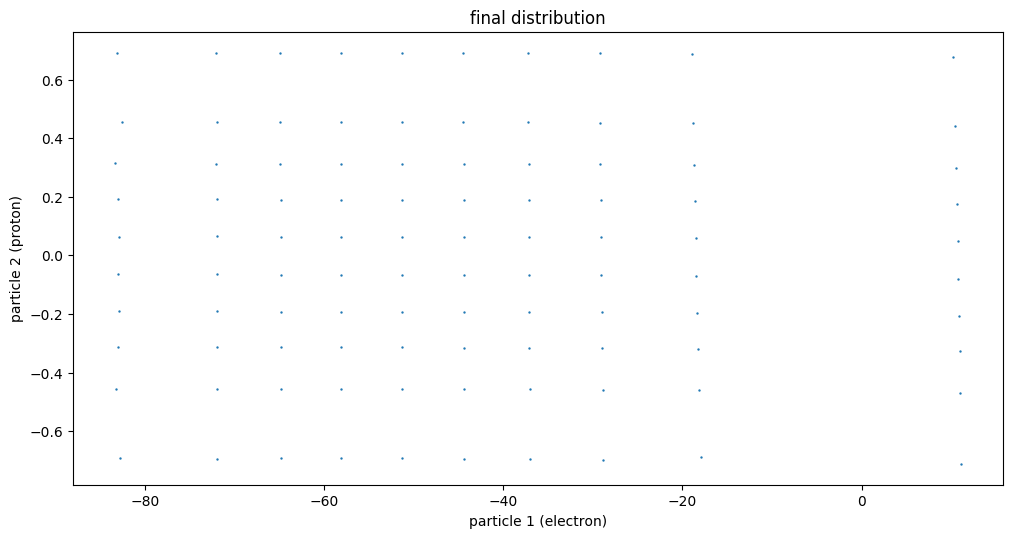

In [118]:
fig = figure(figsize=(12,6),dpi=100)
scatter(debound(x[0]).eval(),debound(x[1]).eval(),s=0.5)
title("final distribution")
xlabel('particle 1 (electron)'); ylabel('particle 2 (proton)')
show()

In [119]:
from matplotlib.pyplot import hist

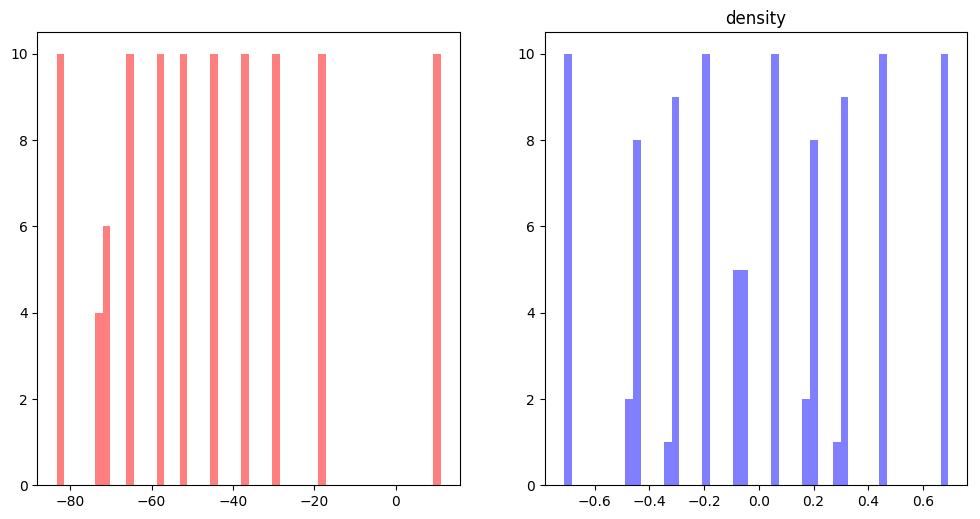

In [120]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.add_subplot(121)
ax1.hist(debound(x[0]).eval().flatten(),50,color='red',alpha=0.5)
ax1=fig.add_subplot(122)
ax1.hist(debound(x[1]).eval().flatten(),50,color='blue',alpha=0.5)
title('density')
show()

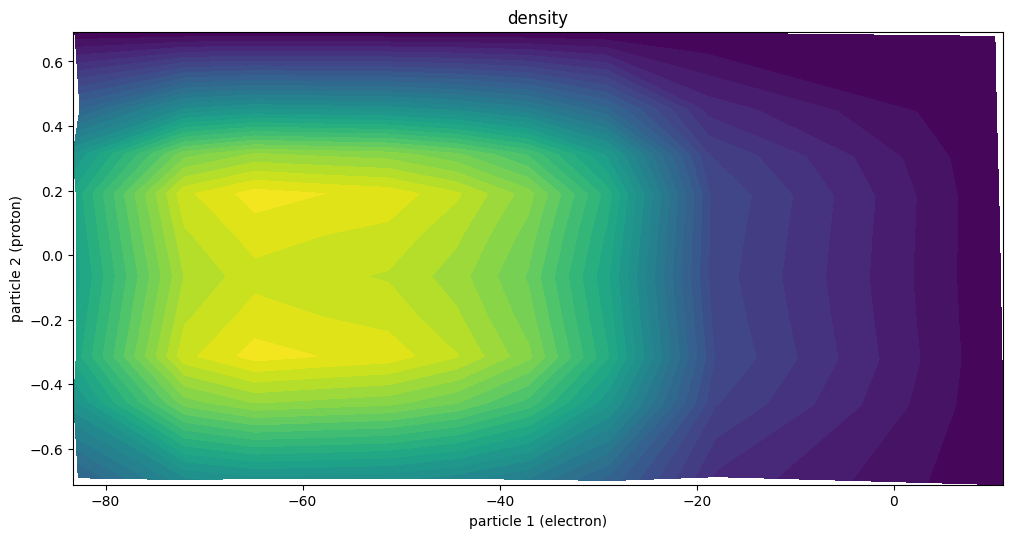

In [121]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.add_subplot(111)
#ax1.set_aspect('equal')
ax1.contourf(debound(x[0]).eval(),debound(x[1]).eval(),D_(x.eval()),30)
title('density')
xlabel('particle 1 (electron)'); ylabel('particle 2 (proton)')
show()

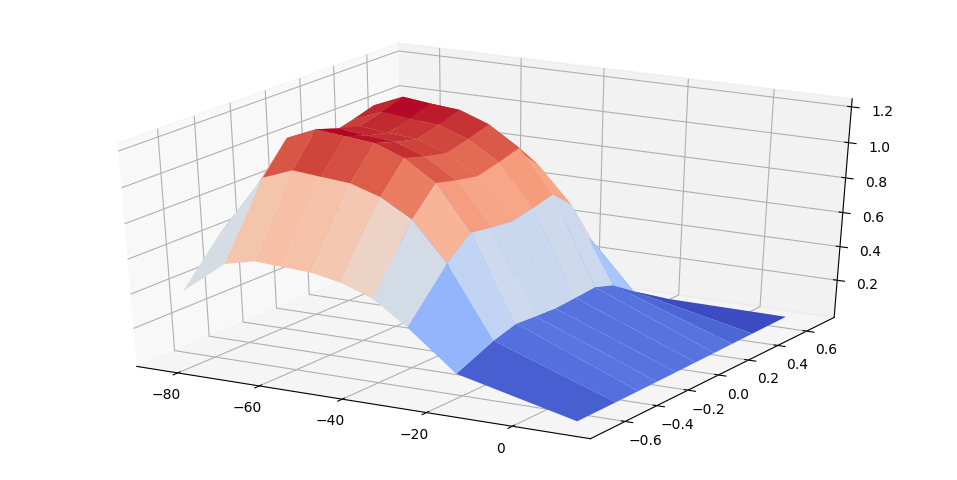

In [122]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(111, projection='3d')
# Plot the surface
ax1.plot_surface(debound(x[0]).eval(),debound(x[1]).eval(),D_(x.get_value()), cmap=coolwarm, linewidth=0, antialiased=True)
#ax1.view_init(50, 40)
show()

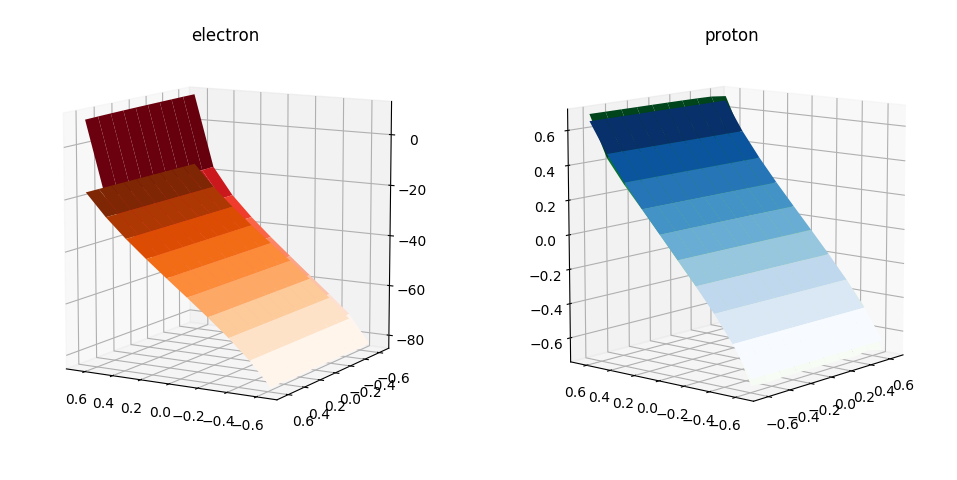

In [123]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
# Plot the surface
p1=ax1.plot_surface(xy[0], xy[1], debound(x[0]).eval(), cmap=Reds, linewidth=0, antialiased=True, label='final')
p2=ax1.plot_surface(xy[0], xy[1], debound(b0[0]), cmap=Oranges, linewidth=0, antialiased=True, label='initial')
ax1.set_title('electron')
ax1.view_init(10, 120)
p3=ax2.plot_surface(xy[0], xy[1], debound(x[1]).eval(), cmap=Greens, linewidth=0, antialiased=True,label='final')
p4=ax2.plot_surface(xy[0], xy[1], debound(b0[1]), cmap=Blues, linewidth=0, antialiased=True, label='initial')
ax2.set_title('proton')
ax2.view_init(10, -140)
show()